In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import spatial

% matplotlib inline

## Part (a) &mdash; Color-Magnitude Diagram for M92

In [3]:
### photometry data location
photpath = '/Users/iene/Documents/Classes/ay250_fall2016/pset3/data/n6093_to_n6341_REAL/NGC6341.M92/final/REAL/NGC6341R.RDVIQ.cal.adj.zpt.txt'
### read in data
photdata = np.genfromtxt(photpath, skip_header=1, unpack=True)

`Readme` instructions say the `Vvega` column is F606W and the `Ivega` column is F814W. The corresponding F606W-F814W is given by the column `VIvega`.

In [4]:
### let's extract these columns for plotting
f606w = photdata[3]
f814w = photdata[7]
color = photdata[5]
### also get errors for later
err606 = photdata[4]
err814 = photdata[8]
errcol = photdata[6]

In [5]:
### turns out there's one point with a very high color value (60ish) (not sure why), so let's ignore it
f606w = f606w[np.where(color < 60)[0]]
f814w = f814w[np.where(color < 60)[0]]
color = color[np.where(color < 60)[0]]
# and for errors
err606 = err606[np.where(color < 60)[0]]
err814 = err814[np.where(color < 60)[0]]
errcol = errcol[np.where(color < 60)[0]]

In [6]:
### also, there is some garbage where the error on 606 and color is 99.999
ii = np.where(errcol != 99.999)
f606w = f606w[ii]
f814w = f814w[ii]
color = color[ii]
err606 = err606[ii]
err814 = err814[ii]
errcol = errcol[ii]

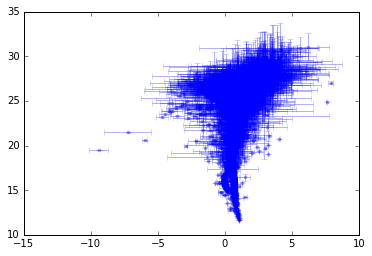

In [7]:
### now let's hope everything is nicely cleaned up
plt.errorbar(f606w-f814w, f606w, xerr=errcol, yerr=err606,fmt='.', alpha=0.3)
plt.show()

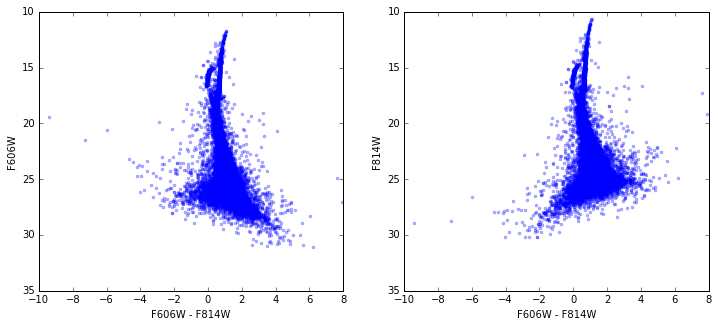

In [7]:
### now let's plot -- without error bars because that would be too much
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].plot(f606w-f814w, f606w, '.', alpha=0.3)
ax1[0].invert_yaxis()
ax1[0].set_xlabel('F606W - F814W')
ax1[0].set_ylabel('F606W')
ax1[1].plot(f606w-f814w, f814w, '.', alpha=0.3)
ax1[1].invert_yaxis()
ax1[1].set_xlabel('F606W - F814W')
ax1[1].set_ylabel('F814W')
plt.show()

The CMDs look good. But since MS is not that sensitive to age, let's cut out MS stars when trying to do isochrone fitting. To this end, I choose to cut out all starts with `F606W` magnitude greater than 20. 

In [8]:
good = np.where(f606w < 20)
good606 = f606w[good]
good814 = f814w[good]
goodcol = color[good]
gerr606 = err606[good]
gerr814 = err814[good]
gerrcol = errcol[good]

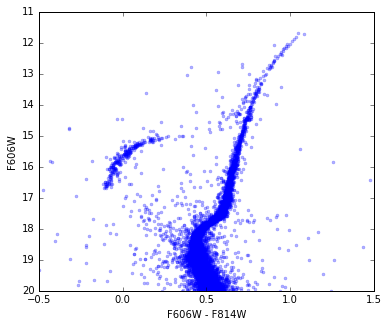

In [88]:
### now let's plot -- without error bars because that would be too much
fig = plt.subplots(figsize=(6,5))
plt.plot(goodcol, good606, '.', alpha=0.3)
plt.gca().invert_yaxis()
plt.xlim([-0.5,1.5])
plt.xlabel('F606W - F814W')
plt.ylabel('F606W')
plt.show()

## Part (b) &mdash; Isochrone fitting

From class discussion and reading about M92 etc, it seems that it is an old, metal-poor cluster, so it doesn't make sense to explore the parameter space of small ages and high metallicities.

So, let's say the age of the cluster is between 8 and 18 Gyr, which in log space corresponds to values of $\log_{10}$(age) between 9.9 and 10.26. In steps of 0.05 dex, this gives 8 values.

Also, let's say metallicity is between -2.5 and -2.0. (most literature values seems to be close to -2.3) In steps of 0.05 dex, this gives 11 values.

There is also the issue of extinction. All of the papers I've seen use $E(B-V)$ = 0.02, which is consistent with the value quoted on NED of $A_V$ = 0.061 (this is assuming that $R_V$ = 3.1, which a lot of people seem to do). So at this point I'm just going to do what everybody else seems to do and use the NED values for extinction: $A_R$ = 0.048 and $A_I$ = 0.034, which gives a reddening of $E(R-I)$ = 0.014.

Also, since the isochrones don't incorporate distance in their calculations, I'm just going to use the distance modulus value of 14.65 which was found by Dotter and Chaboyer.

I don't think I'm going to get an "automated" isochrone fitter that works, so I'm going to do a "chi by eye" fit (because that's what everybody has been doing for the past 50 years so ...) and maybe try to do an isochrone fitter later, if I have time. To this end, here is the disclaimer that I'm just going to report whatever isochrone looks to me to be the best fit.

In [13]:
## parameter space
log10ages = [9.90, 9.95, 10.00, 10.05, 10.10, 10.15, 10.20, 10.25]
feh = [2.50, 2.45, 2.40, 2.35, 2.30, 2.25, 2.20, 2.15, 2.10, 2.05, 2.00]
eri = 0.014 # reddening
ar = 0.048 # R extinction
DM = 14.65 # distance modulus

In [127]:
### isochrone data location
isodir = '/Users/iene/Documents/Classes/ay250_fall2016/pset3/data/isochrones/'
isopath = lambda feh: os.path.join(isodir, 'hst_filter', 'MIST_iso_feh{0:.2f}.txt'.format(feh))

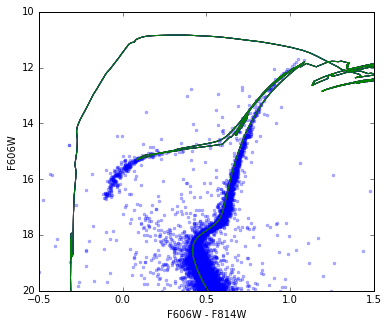

In [92]:
fig = plt.figure(figsize=(6,5))
plt.plot(good606-good814, good606, '.', alpha=0.3)

#isodata = np.genfromtxt('/Users/iene/Documents/Classes/ay250_fall2016/pset3/data/isochrones/hst_filter/MIST_iso_trial1.txt', skip_header=12, names=True, unpack=True)
isodata = np.genfromtxt(isopath(2.00), skip_header=12, names=True, unpack=True)
ages = isodata['log10_isochrone_age_yr']
for age_i in log10ages:
    age = np.where(np.round(ages, decimals=2) == 10.15)
    #print "Grabbing magnitudes"
    iso606 = isodata['ACS_WFC_F606W'][age]
    iso814 = isodata['ACS_WFC_F814W'][age]
    isocolor = iso606 - iso814
    ### let's also cut the isochrone magnitudes higher than 20
    isogood = np.where(iso606 + ar + DM < 20)
    iso606 = iso606[isogood]
    isocolor = isocolor[isogood]
    # correct for reddening and extinction
    #print "Dealing with reddening, extinction, DM"
    iso606 += ar + 14.65
    isocolor += eri
    plt.plot(isocolor, iso606)
plt.gca().invert_yaxis()
plt.xlim([-0.5,1.5])
plt.xlabel('F606W - F814W')
plt.ylabel('F606W')
plt.show()

Woah, [Fe/H] = -2.00 isochrones show some very weird behavior up top, so I think it's safe to say they're not a good fit.

So let's just look at fixed age and varying metallicity (without [Fe/H] = -2.00).

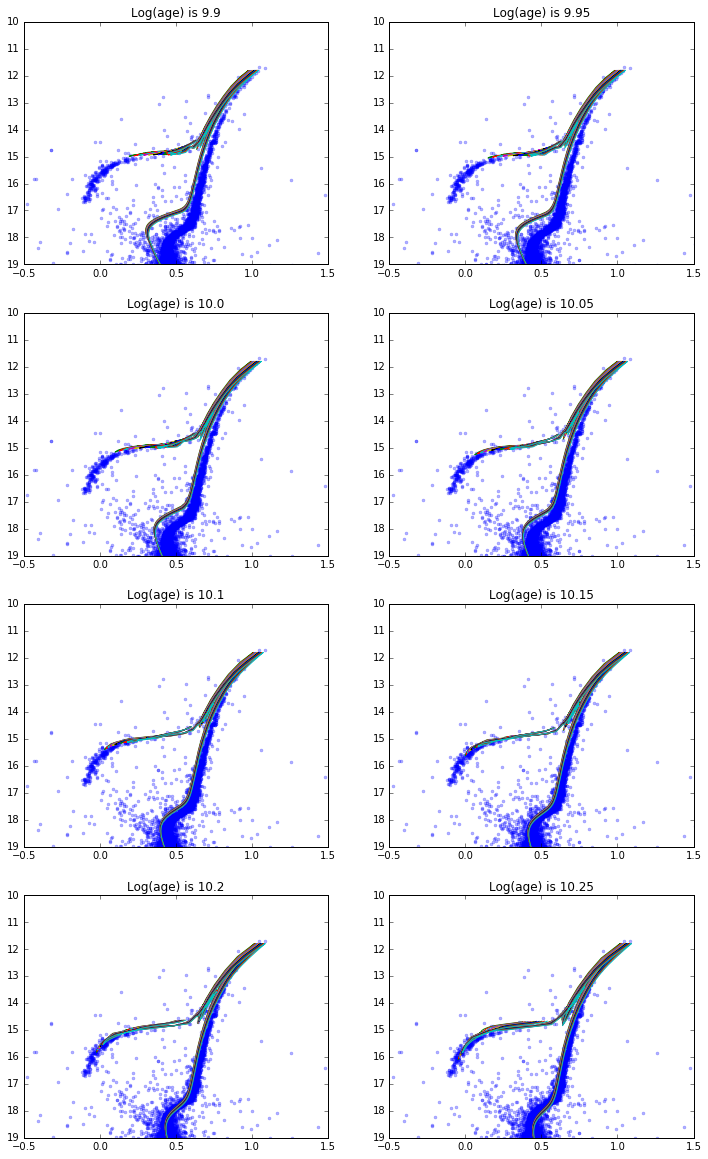

In [83]:
fig, axarr = plt.subplots(4,2,figsize=(12,5*4))
for num, age_i in enumerate(log10ages):
    #print "{0:.2E}".format(10**age_i), age_i
    #plt.plot(good606-good814, good606, '.', alpha=0.3)
    row = num / 2
    col = num % 2
    axarr[row, col].plot(color, f606w, '.', alpha=0.3)
    for met in [2.50, 2.45, 2.40, 2.35, 2.30, 2.25, 2.20, 2.15, 2.10, 2.05]:
        # let's grab an isochrone
        #print "Grabbing isochrone"
        isodata = np.genfromtxt(isopath(met), skip_header=12, names=True, unpack=True)
        ages = isodata['log10_isochrone_age_yr']
        age = np.where(np.round(ages, decimals=2) == age_i)
        #print "Grabbing magnitudes"
        iso606 = isodata['ACS_WFC_F606W'][age]
        iso814 = isodata['ACS_WFC_F814W'][age]
        isocolor = iso606 - iso814
        ### let's also cut the isochrone magnitudes higher than 20
        #isogood = np.where(iso606 + ar + 15.0 < 20)
        #iso606 = iso606[isogood]
        #isocolor = isocolor[isogood]
        # correct for reddening and extinction
        #print "Dealing with reddening, extinction, DM"
        iso606 += ar + DM
        isocolor += eri
        axarr[row,col].plot(isocolor, iso606)
    axarr[row,col].invert_yaxis()
    axarr[row,col].set_xlim([-0.5,1.5])
    axarr[row,col].set_ylim(bottom = 19)
    axarr[row,col].set_title('Log(age) is {}'.format(age_i))
    
plt.show()

So, based on age, the isochrones that best fit the CMD are the ones for $\log_{10}$(age) = 10.1, 10.15, and 10.2.

Now let's try to differentiate between metallicities. To this end, let's plot the three ages selected above and restrict out attention to magnitudes smaller than 15.

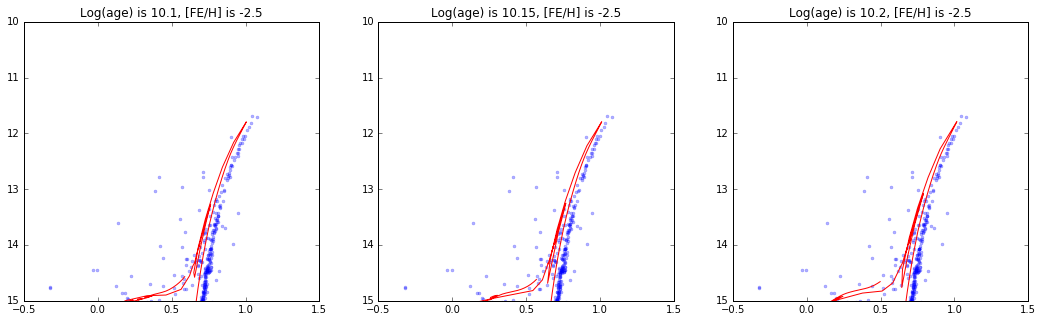

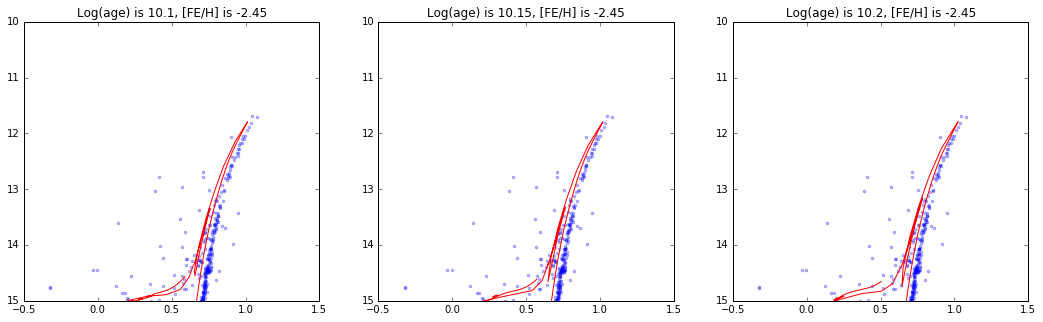

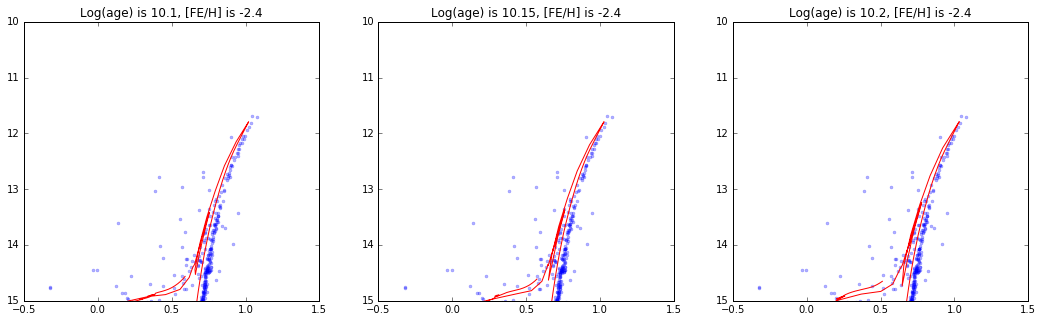

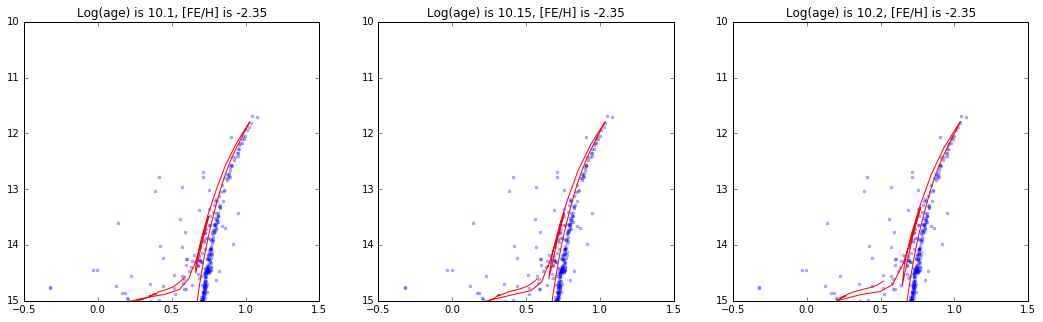

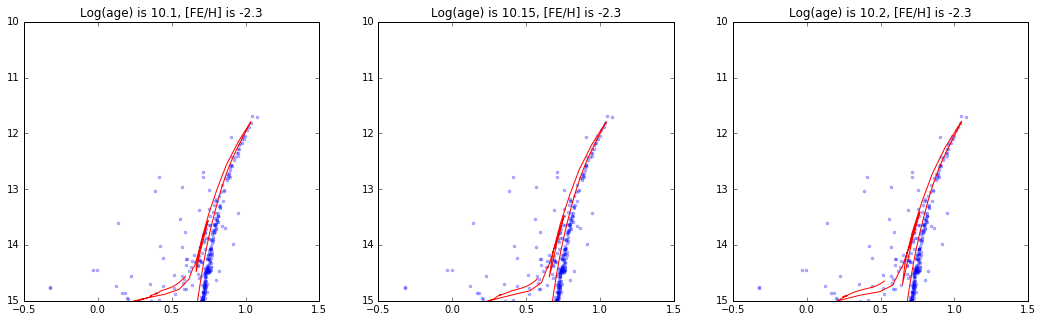

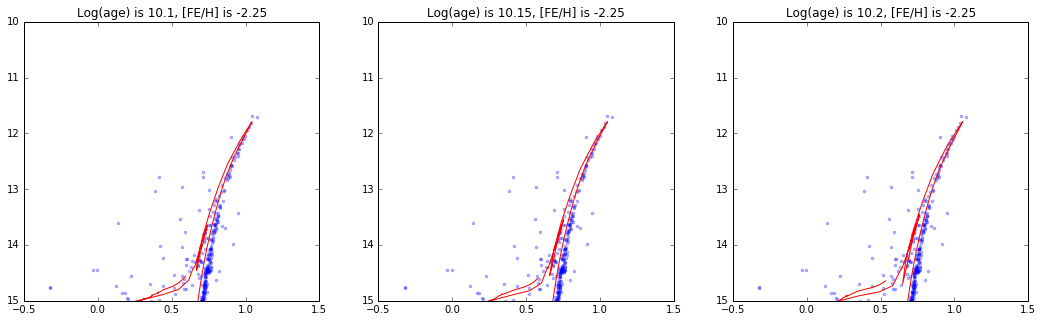

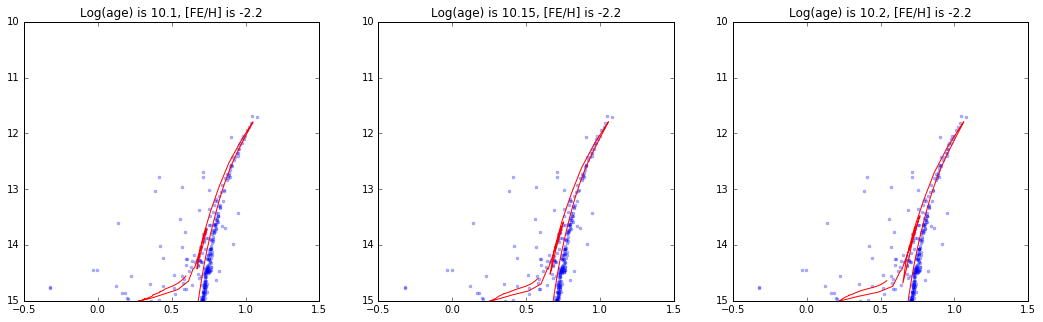

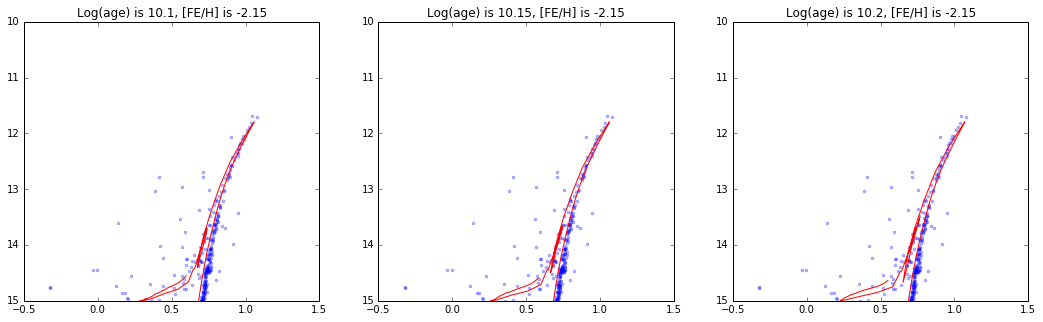

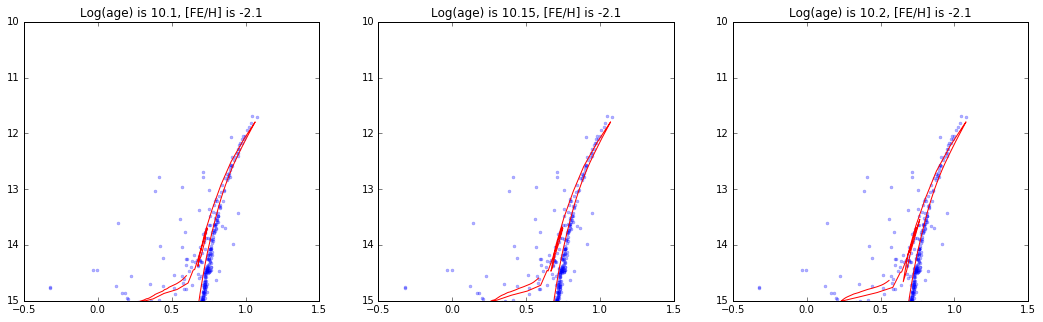

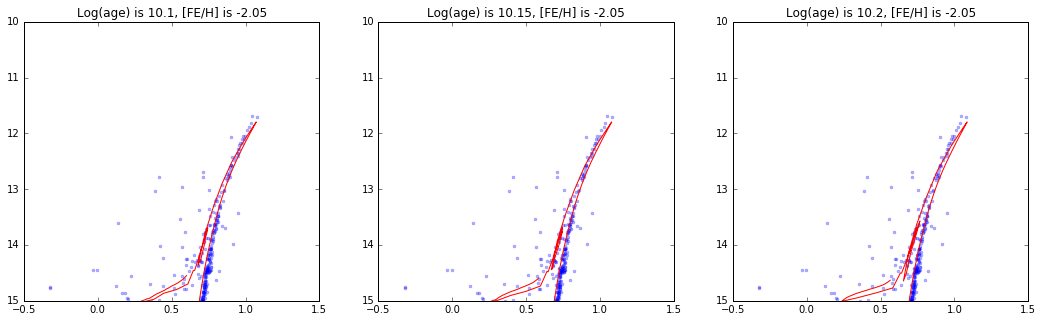

In [156]:
for met in [2.50, 2.45, 2.40, 2.35, 2.30, 2.25, 2.20, 2.15, 2.10, 2.05]:
    fig, axarr = plt.subplots(1,3,figsize=(6*3,5*1))
    for num, age_i in enumerate([10.10, 10.15, 10.20]):
        #print "{0:.2E}".format(10**age_i), age_i
        #plt.plot(good606-good814, good606, '.', alpha=0.3)
        col = num % 3
        axarr[col].plot(color, f606w, '.', alpha=0.3)
        #for met in [2.50]:
        #for met in [2.50, 2.45, 2.40, 2.35, 2.30, 2.25, 2.20, 2.15, 2.10, 2.05]:
        # let's grab an isochrone
        #print "Grabbing isochrone"
        isodata = np.genfromtxt(isopath(met), skip_header=12, names=True, unpack=True)
        ages = isodata['log10_isochrone_age_yr']
        age = np.where(np.round(ages, decimals=2) == age_i)
        #print "Grabbing magnitudes"
        iso606 = isodata['ACS_WFC_F606W'][age]
        iso814 = isodata['ACS_WFC_F814W'][age]
        isocolor = iso606 - iso814
        ### let's also cut the isochrone magnitudes higher than 20
        #isogood = np.where(iso606 + ar + 15.0 < 20)
        #iso606 = iso606[isogood]
        #isocolor = isocolor[isogood]
        # correct for reddening and extinction
        #print "Dealing with reddening, extinction, DM"
        iso606 += ar + DM
        isocolor += eri
        axarr[col].plot(isocolor, iso606, 'r')
        axarr[col].invert_yaxis()
        axarr[col].set_xlim([-0.5,1.5])
        axarr[col].set_ylim(bottom = 15)
        axarr[col].set_title('Log(age) is {}, [FE/H] is {}'.format(age_i, -1*met))

    plt.show()

For all ages, models with [Fe/H] $\leq$ -2.35 don't look like a good fit, and neither do models with [Fe/H] $\geq$ -2.15.

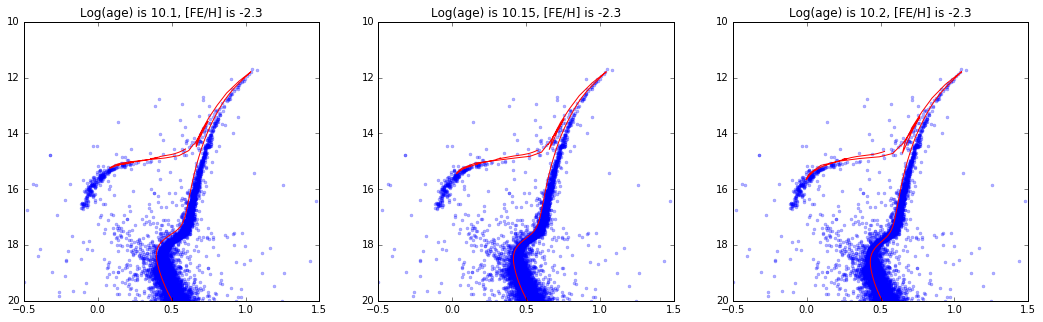

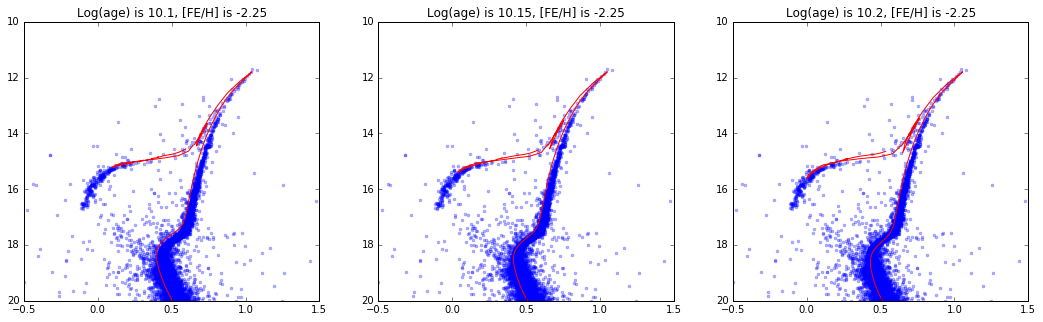

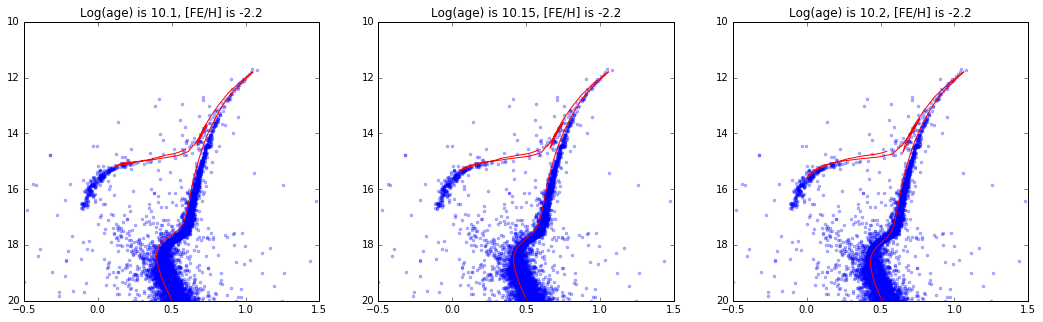

In [157]:
for met in [2.30, 2.25, 2.20]:
    fig, axarr = plt.subplots(1,3,figsize=(6*3,5*1))
    for num, age_i in enumerate([10.10, 10.15, 10.20]):
        #print "{0:.2E}".format(10**age_i), age_i
        #plt.plot(good606-good814, good606, '.', alpha=0.3)
        col = num % 3
        axarr[col].plot(color, f606w, '.', alpha=0.3)
        #for met in [2.50]:
        #for met in [2.50, 2.45, 2.40, 2.35, 2.30, 2.25, 2.20, 2.15, 2.10, 2.05]:
        # let's grab an isochrone
        #print "Grabbing isochrone"
        isodata = np.genfromtxt(isopath(met), skip_header=12, names=True, unpack=True)
        ages = isodata['log10_isochrone_age_yr']
        age = np.where(np.round(ages, decimals=2) == age_i)
        #print "Grabbing magnitudes"
        iso606 = isodata['ACS_WFC_F606W'][age]
        iso814 = isodata['ACS_WFC_F814W'][age]
        isocolor = iso606 - iso814
        ### let's also cut the isochrone magnitudes higher than 20
        #isogood = np.where(iso606 + ar + 15.0 < 20)
        #iso606 = iso606[isogood]
        #isocolor = isocolor[isogood]
        # correct for reddening and extinction
        #print "Dealing with reddening, extinction, DM"
        iso606 += ar + DM
        isocolor += eri
        axarr[col].plot(isocolor, iso606, 'r')
        axarr[col].invert_yaxis()
        axarr[col].set_xlim([-0.5,1.5])
        axarr[col].set_ylim(bottom = 20)
        axarr[col].set_title('Log(age) is {}, [FE/H] is {}'.format(age_i, -1*met))

    plt.show()

Based on fit for the main sequence turn off, the best-fitting age I estimate to be $\log_{10}$(age) = 10.15.

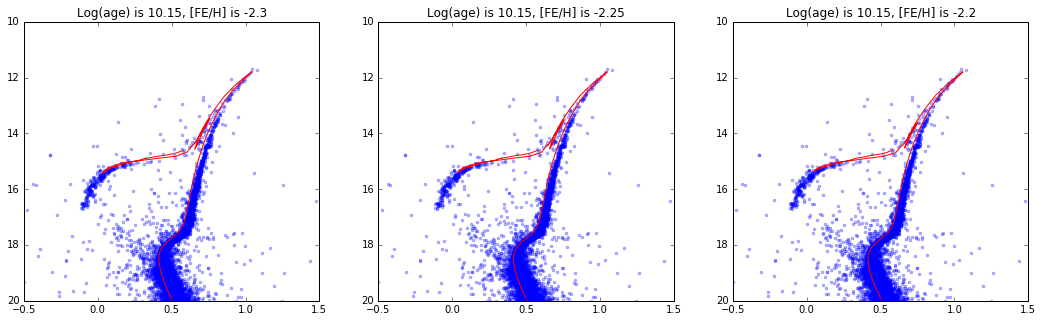

In [158]:
for age_i in [10.15]:
    fig, axarr = plt.subplots(1,3,figsize=(6*3,5*1))
    for num, met in enumerate([2.30, 2.25, 2.20]):
        #print "{0:.2E}".format(10**age_i), age_i
        #plt.plot(good606-good814, good606, '.', alpha=0.3)
        col = num % 3
        axarr[col].plot(color, f606w, '.', alpha=0.3)
        #for met in [2.50]:
        #for met in [2.50, 2.45, 2.40, 2.35, 2.30, 2.25, 2.20, 2.15, 2.10, 2.05]:
        # let's grab an isochrone
        #print "Grabbing isochrone"
        isodata = np.genfromtxt(isopath(met), skip_header=12, names=True, unpack=True)
        ages = isodata['log10_isochrone_age_yr']
        age = np.where(np.round(ages, decimals=2) == age_i)
        #print "Grabbing magnitudes"
        iso606 = isodata['ACS_WFC_F606W'][age]
        iso814 = isodata['ACS_WFC_F814W'][age]
        isocolor = iso606 - iso814
        ### let's also cut the isochrone magnitudes higher than 20
        #isogood = np.where(iso606 + ar + 15.0 < 20)
        #iso606 = iso606[isogood]
        #isocolor = isocolor[isogood]
        # correct for reddening and extinction
        #print "Dealing with reddening, extinction, DM"
        iso606 += ar + DM
        isocolor += eri
        axarr[col].plot(isocolor, iso606, 'r')
        axarr[col].invert_yaxis()
        axarr[col].set_xlim([-0.5,1.5])
        axarr[col].set_ylim(bottom = 20)
        axarr[col].set_title('Log(age) is {}, [FE/H] is {}'.format(age_i, -1*met))

    plt.show()

At this point, I can't really tell the difference between the 3 different metallicity models, so I'll just choose the one with [Fe/H] = -2.25 as the best fitting isochrone and plot that one.

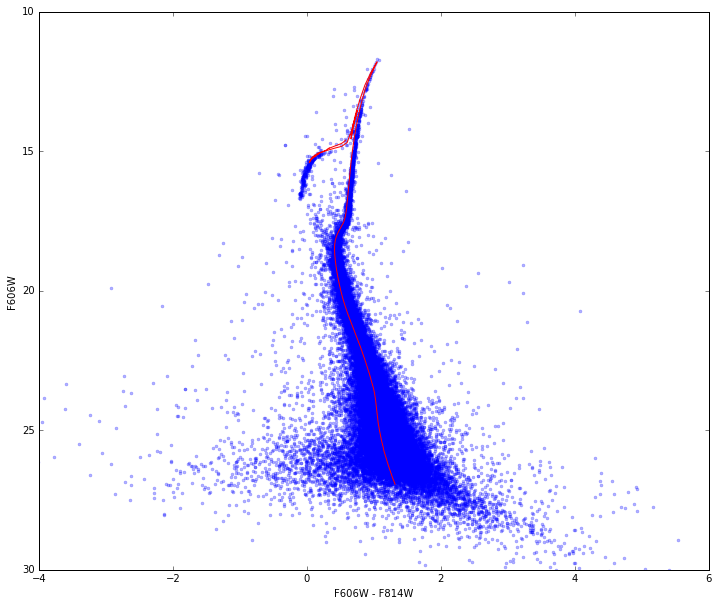

In [119]:
fig = plt.figure(figsize=(12,10))
plt.plot(color, f606w, '.', alpha=0.3)

#isodata = np.genfromtxt('/Users/iene/Documents/Classes/ay250_fall2016/pset3/data/isochrones/hst_filter/MIST_iso_trial1.txt', skip_header=12, names=True, unpack=True)
isodata = np.genfromtxt(isopath(2.25), skip_header=12, names=True, unpack=True)
ages = isodata['log10_isochrone_age_yr']
age = np.where(np.round(ages, decimals=2) == 10.15)
#print "Grabbing magnitudes"
iso606 = isodata['ACS_WFC_F606W'][age]
iso814 = isodata['ACS_WFC_F814W'][age]
isocolor = iso606 - iso814
### let's also cut the isochrone magnitudes higher than 20
#isogood = np.where(iso606 + ar + DM < 20)
#iso606 = iso606[isogood]
#isocolor = isocolor[isogood]
# correct for reddening and extinction
#print "Dealing with reddening, extinction, DM"
iso606 += ar + DM
isocolor += eri
plt.plot(isocolor, iso606, 'r')
plt.gca().invert_yaxis()
plt.xlim([-4,6])
plt.ylim(bottom=30)
plt.xlabel('F606W - F814W')
plt.ylabel('F606W')
plt.show()

## Part (c) &mdash; PARSEC isochrone fitting

In [136]:
### location of files
parsecpath = lambda feh: os.path.join(isodir, 'parsec', '{0:.2f}.dat'.format(feh))

Turns out PARSEC models are even more limited that MIST models, in age and metallicity, so we'll need new age and metallicity values to sample. Basically, I can't get PARSEC to compute isochrones for $\log$(age) $\geq$ 10.1 and [Fe/H] $\leq$ -2.2.

In [161]:
plogage = [9.8, 9.85, 9.9, 9.95, 10.0, 10.05]
pfeh = [2.15, 2.10, 2.05, 2.00, 1.95, 1.90, 1.85, 1.80, 1.75]

IndexError: index 3 is out of bounds for axis 0 with size 3

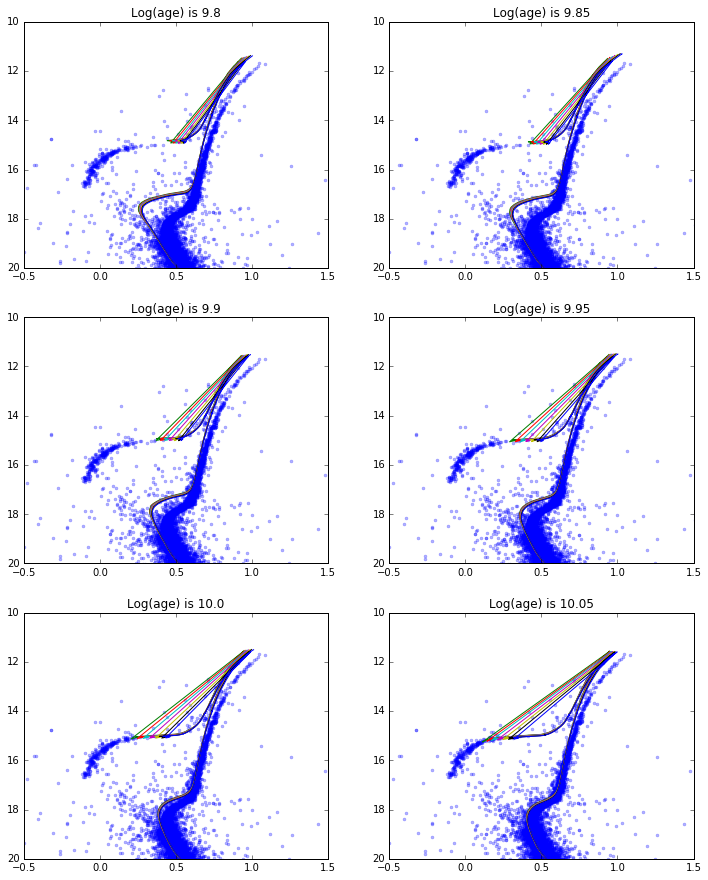

In [150]:
fig, axarr = plt.subplots(3,2,figsize=(12,5*3))
for num, age_i in enumerate(plogage):
    #print "{0:.2E}".format(10**age_i), age_i
    #plt.plot(good606-good814, good606, '.', alpha=0.3)
    row = num / 2
    col = num % 2
    axarr[row, col].plot(color, f606w, '.', alpha=0.3)
    for met in pfeh:
        # let's grab an isochrone
        #print "Grabbing isochrone"
        parsecdata = np.genfromtxt(parsecpath(met), skip_header=13, names=True, unpack=True)
        ages = parsecdata['logageyr']
        age = np.where(np.round(ages, decimals=2) == age_i)
        #print "Grabbing magnitudes"
        p606 = parsecdata['F606W'][age]
        p814 = parsecdata['F814W'][age]
        pcolor = p606 - p814
        ### let's also cut the isochrone magnitudes higher than 20
        #isogood = np.where(iso606 + ar + 15.0 < 20)
        #iso606 = iso606[isogood]
        #isocolor = isocolor[isogood]
        # correct for reddening and extinction
        #print "Dealing with reddening, extinction, DM"
        p606 += ar + DM
        pcolor += eri
        axarr[row,col].plot(pcolor, p606)
    axarr[row,col].invert_yaxis()
    axarr[row,col].set_xlim([-0.5,1.5])
    axarr[row,col].set_ylim(bottom = 20)
    axarr[row,col].set_title('Log(age) is {}'.format(age_i))
    
plt.show()

It seems that $\log$(age) = 10.0 and 10.05 best fit the CMD.

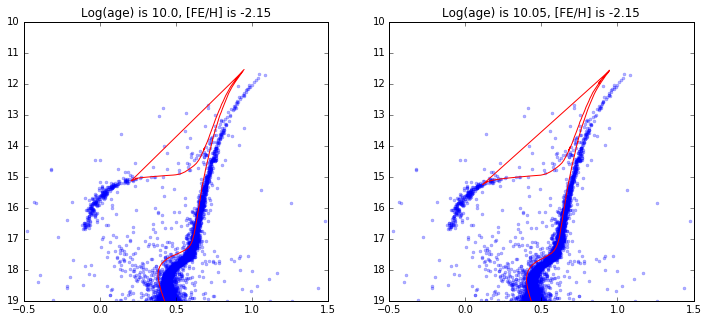

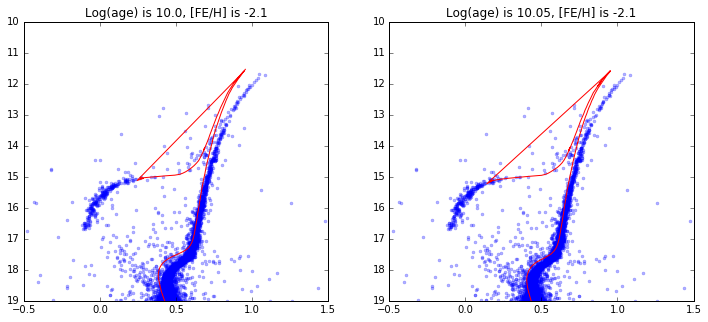

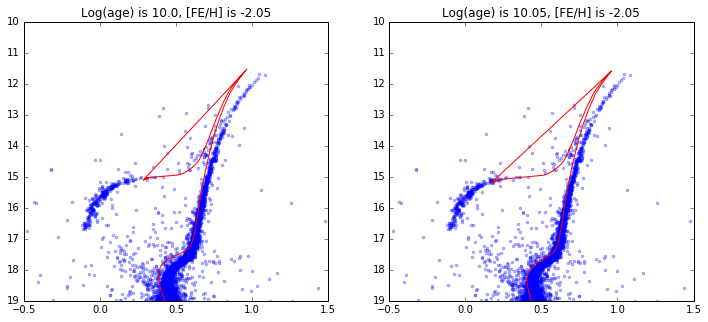

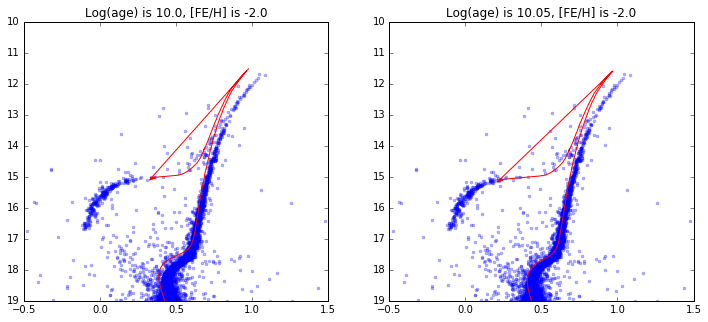

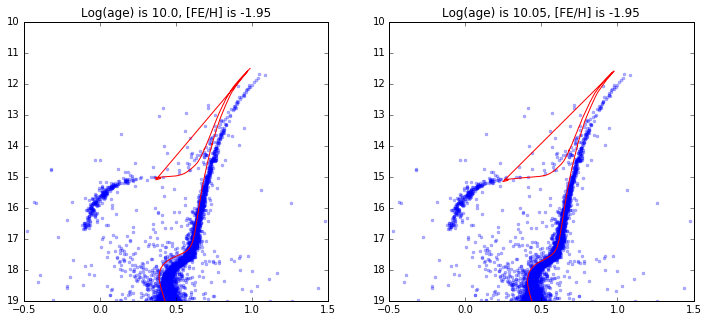

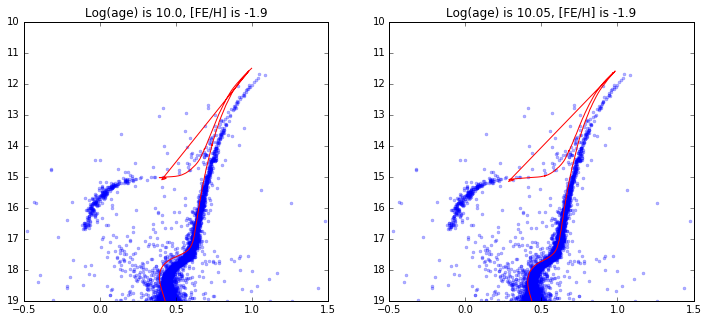

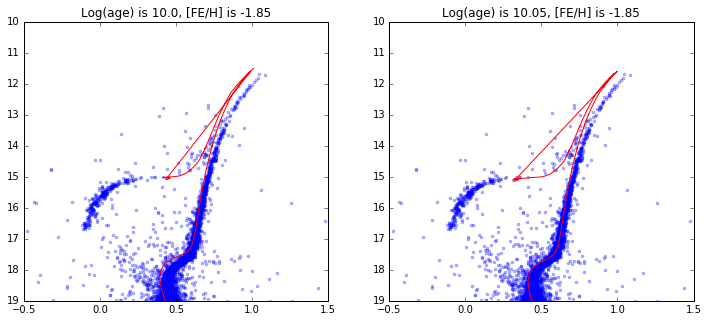

In [155]:
for met in pfeh:
    fig, axarr = plt.subplots(1,2,figsize=(6*2,5*1))
    for num, age_i in enumerate([10.00, 10.05]):
        #print "{0:.2E}".format(10**age_i), age_i
        #plt.plot(good606-good814, good606, '.', alpha=0.3)
        col = num % 2
        axarr[col].plot(color, f606w, '.', alpha=0.3)
        #for met in [2.50]:
        #for met in [2.50, 2.45, 2.40, 2.35, 2.30, 2.25, 2.20, 2.15, 2.10, 2.05]:
        # let's grab an isochrone
        #print "Grabbing isochrone"
        parsecdata = np.genfromtxt(parsecpath(met), skip_header=13, names=True, unpack=True)
        ages = parsecdata['logageyr']
        age = np.where(np.round(ages, decimals=2) == age_i)
        #print "Grabbing magnitudes"
        p606 = parsecdata['F606W'][age]
        p814 = parsecdata['F814W'][age]
        pcolor = p606 - p814
        ### let's also cut the isochrone magnitudes higher than 20
        #isogood = np.where(iso606 + ar + 15.0 < 20)
        #iso606 = iso606[isogood]
        #isocolor = isocolor[isogood]
        # correct for reddening and extinction
        #print "Dealing with reddening, extinction, DM"
        p606 += ar + DM
        pcolor += eri
        axarr[col].plot(pcolor, p606, 'r')
        axarr[col].invert_yaxis()
        axarr[col].set_xlim([-0.5,1.5])
        axarr[col].set_ylim(bottom = 19)
        axarr[col].set_title('Log(age) is {}, [FE/H] is {}'.format(age_i, -1*met))

    plt.show()

Looking at the two ages side by side and separated by metallicity, it seems that $\log$(age) = 10.05 is the better fit.

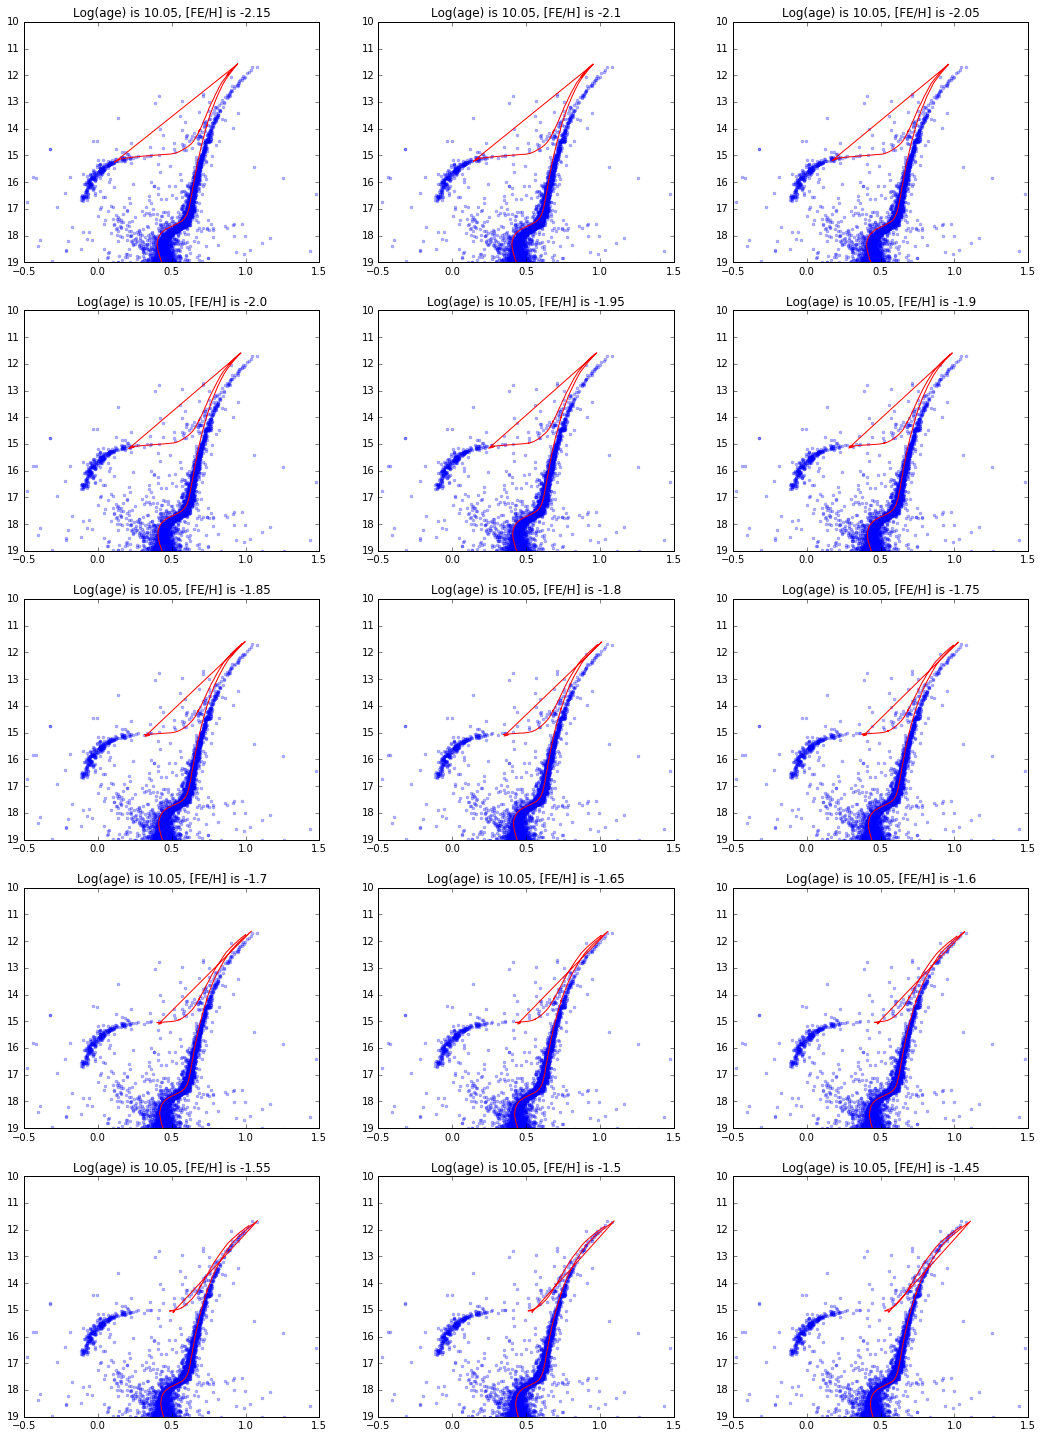

In [170]:
fig, axarr = plt.subplots(5,3,figsize=(6*3,5*5))
for num, met in enumerate(pfeh + [1.70, 1.65, 1.60, 1.55, 1.50, 1.45]):
    #print "{0:.2E}".format(10**age_i), age_i
    #plt.plot(good606-good814, good606, '.', alpha=0.3)
    row = num / 3
    col = num % 3
    axarr[row, col].plot(color, f606w, '.', alpha=0.3)
    #for met in [2.50]:
    #for met in [2.50, 2.45, 2.40, 2.35, 2.30, 2.25, 2.20, 2.15, 2.10, 2.05]:
    # let's grab an isochrone
    #print "Grabbing isochrone"
    parsecdata = np.genfromtxt(parsecpath(met), skip_header=13, names=True, unpack=True)
    ages = parsecdata['logageyr']
    age = np.where(np.round(ages, decimals=2) == 10.05)
    #print "Grabbing magnitudes"
    p606 = parsecdata['F606W'][age]
    p814 = parsecdata['F814W'][age]
    pcolor = p606 - p814
    ### let's also cut the isochrone magnitudes higher than 20
    #isogood = np.where(iso606 + ar + 15.0 < 20)
    #iso606 = iso606[isogood]
    #isocolor = isocolor[isogood]
    # correct for reddening and extinction
    #print "Dealing with reddening, extinction, DM"
    p606 += ar + DM
    pcolor += eri
    axarr[row, col].plot(pcolor, p606, 'r')
    axarr[row, col].invert_yaxis()
    axarr[row, col].set_xlim([-0.5,1.5])
    axarr[row, col].set_ylim(bottom = 19)
    axarr[row, col].set_title('Log(age) is {}, [FE/H] is {}'.format(10.05, -1*met))

plt.show()

Best fit metallicities seem to be -1.6, -1.55 and -1.5.

## Part (d) &mdash; Comparison of the two models

Best fitting MIST parameters are $\log$(age) = 10.15, corresponding to an age of 14.1 Gyr, and [Fe/H]= -2.25 $\pm$ 0.05.

Best fitting PARSEC parameters are $\log$(age) = 10.05, corresponding to an age of 11.2 Gyr, and [Fe/H] = -1.55 $\pm$ 0.05.

For both models I assumed the same value for the extinction $A_R = 0.048$ and distance modulus DM = 14.65 (taken from the NED website and the value reported by Dotter and Chaboyer, respectively). These values seem to be a fairly good fit.

Although the actual values of the best fit parameters are quite different between the two models, nonetheless they both agree on the fact that M92 is an old and metal-poor cluster, although the PARSEC best fit isochrone seems to indicate a younger age and a bit higher metallicity than the MIST best fit isochrone. However, as previously mentioned, the PARSEC isochrones don't cover the same range of parameters, so it feels a bit like comparing apples to oranges.

If we check the literature, we find quite a range of values of each parameter. A few examples are:
* age: 13.5 Gyr, 16 Gyr, 14-18 Gyr
* [Fe/H]: -2.3, -2.28, -2.38, -2.03, -2.27
* reddening E(B-V): 0.04, 0.02, 0.023, 0.025 $\pm$ 0.010
* distance modulus: 14.65, 14.58, 14.75, 14.6, 14.74

The relevant papers are Dotter and Chaboyer (2007), Stetson and Harris (1988), Kraft and Ivans (2004), Ruelas-Mayorga and Sánchez (2005), VandenBerg (2016) and DiCecco (2010).

The MIST best fit parameters are closer to the values reported in the literature.

### Automated isochrone fitter here -- not working yet

In [ ]:
### likelihood related madness here
def lnp(data_col, data_606, err_col, err_606, model_col, model_606):
    # create model array of shape [color, 606]
    lnlike = 0
    model_arr = np.array([])
    for i in range(len(model_col)):
        model_arr = np.append(model_arr, [model_col[i], model_606[i]])
    model_arr = np.resize(model_arr, (len(model_col),2))
    for j in range(len(data_col)):
        point = [data_col[j], data_606[j]]
        nearest_pt = model_arr[spatial.KDTree(model_arr).query(point)[1]]
        lnlike_pt = (point[0]-nearest_pt[0])**2/(2*err_col[j]**2) + (point[1]-nearest_pt[1])**2/(2*err_606[j]**2) + \
        np.log(2*np.pi*err_col[j]*err_606[j])
        if np.isfinite(lnlike_pt):
            lnlike -= lnlike_pt
        
    return lnlike

In [ ]:
chi_dict = {}
for met in feh:
    # let's grab an isochrone
    print "Grabbing isochrone"
    isodata = np.genfromtxt(isopath(met), skip_header=12, names=True, unpack=True)
    ages = isodata['log10_isochrone_age_yr']
    for age_i in log10ages:
        age = np.where(np.round(ages, decimals=2) == age_i)
        print "Grabbing magnitudes"
        iso606 = isodata['Bessell_R'][age]
        iso814 = isodata['Bessell_I'][age]
        isocolor = iso606 - iso814
        ### let's also cut the isochrone magnitudes higher than 20
        isogood = np.where(iso606 + ar + DM < 20)
        iso606 = iso606[isogood]
        isocolor = isocolor[isogood]
        # correct for reddening and extinction
        print "Dealing with reddening, extinction, DM"
        iso606 += ar + DM
        isocolor += eri
        # compute log-like here
        print "Computing log-like"
        lnp_i = lnp(goodcol, good606, gerrcol, gerr606, isocolor, iso606)
        # add this value + parameter values to a dictionary
        print "Saving to dict"
        chi_dict[lnp_i] = [met, age_i]